In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Standard
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from PIL import Image
import scipy
import os
import cv2

# # Tensorflow and Keras
# from keras.datasets import mnist
# from keras.models import Sequential, Model, Input
# from keras.layers import Dense, Dropout, Activation
# from keras.layers import Conv2D, MaxPooling2D, Flatten
# from tensorflow.keras.optimizers import SGD
# from keras.regularizers import l2
# import tensorflow as tf

# Xception because other model not working
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications import Xception, MobileNetV2, VGG16, VGG19
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop

from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

os.chdir('../')
from src import image_manip
from src import my_models as models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Start with histology data
for each 40X, 100X, 200X, 400X, have 644 items for benign and 1300 for malignant

Augment our benign data since we only have ~650 images. This might not be necessary.

In [50]:
files = [f for f in os.listdir('data/Histology/100X/benign')]

for f in files:
    img = Image.open(os.path.join('data/Histology/100X/benign',f))
    x = ip.reshape_image(img)
    ip.create_new_images(x)    


In [40]:
root_dir = '/home/maureen/Documents/Galvanize/Capstone1/Capstone3/Cancer_Prediction'

## Make the model using simplecnn.py

In [149]:
# Assuming input shape = (width, height, channels) NOT (rows, cols, channels)
model = simple_cnn.create_model(input_size=(500,328,3), n_categories=2)

In [185]:
train_path = 'data/Histology/100X/train'
val_path = 'data/Histology/100X/validation'
test_path = 'data/Histology/100X/test'

# Data Generators
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      horizontal_flip=True) 
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Data generators from directory
train_generator = training_datagen.flow_from_directory(train_path, 
                                                       target_size=(500, 328), 
                                                       batch_size=16)
validation_generator = validation_datagen.flow_from_directory(val_path, 
                                                              target_size=(500,328), 
                                                              batch_size=16)
test_generator = test_datagen.flow_from_directory(test_path,
                                                 target_size=(500,328),
                                                 batch_size=16)

In [153]:
model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [158]:
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

callback = keras.callbacks.ModelCheckpoint(filepath='models/simplecnn_whc.h5', save_best_only=True)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs")

In [159]:
model.fit_generator(train_generator,
                   steps_per_epoch=1666//16,
                   epochs=3,
                   validation_data=validation_generator,
                   validation_steps=415//16,
                   callbacks=[callback, tensorboard_callback])

Epoch 1/3
104/104 [==============================] - 429s 4s/step - loss: 4.7324 - accuracy: 0.6897 - val_loss: 4.7928 - val_accuracy: 0.6875
Epoch 2/3
104/104 [==============================] - 421s 4s/step - loss: 4.7503 - accuracy: 0.6927 - val_loss: 2.8757 - val_accuracy: 0.6892
Epoch 3/3
104/104 [==============================] - 420s 4s/step - loss: 4.7965 - accuracy: 0.6897 - val_loss: 6.7100 - val_accuracy: 0.6892


## Try Transfer Learning!

### Histology Data

In [391]:
# Run on Histology data
mag = ['40X', '100X', '200X', '400X']
predictions = []
filenames = []

for m in mag:
    train_path = f'data/Histology/{m}/train'
    val_path = f'data/Histology/{m}/validation'
    test_path = f'data/Histology/{m}/test'
    
    model = models.Xception_model(500,368)
    model.compile_model(train_path, val_path)
    model.fit()
    files, predict = model.predict(test_path)
    
    filenames.append(files)
    predictions.append(predict)

Found 1577 images belonging to 2 classes.
Found 399 images belonging to 2 classes.
Epoch 1/4


ValueError: in user code:

    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:543 train_step  **
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:391 update_state
        self._build(y_pred, y_true)
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:322 _build
        self._metrics, y_true, y_pred)
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1118 map_structure_up_to
        **kwargs)
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1214 map_structure_with_tuple_paths_up_to
        *flat_value_lists)]
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1213 <listcomp>
        results = [func(*args, **kwargs) for args in zip(flat_path_list,
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1116 <lambda>
        lambda _, *values: func(*values),  # Discards the path arg.
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:421 _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:421 <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:440 _get_metric_object
        metric_obj = metrics_mod.get(metric)
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:3358 get
        return deserialize(str(identifier))
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/metrics.py:3349 deserialize
        printable_module_name='metric function')
    /home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:392 deserialize_keras_object
        raise ValueError('Unknown ' + printable_module_name + ':' + object_name)

    ValueError: Unknown metric function:auc


In [378]:
predictions = np.asarray(predictions)
predictions.shape
np.save('filenames.txt', filenames)
# with open('predictionsrmsprop.txt', 'w') as f:
#     f.write('\n'.join(predictions))

In [377]:
filenames

[['test/SOB_B_F-14-25197-40-041.png',
  'test/SOB_B_F-14-29960AB-40-014.png',
  'test/SOB_B_PT-14-21998AB-40-056.png',
  'test/SOB_B_PT-14-22704-40-036.png',
  'test/SOB_B_PT-14-29315EF-40-009.png',
  'test/SOB_B_TA-14-13200-40-006.png',
  'test/SOB_B_TA-14-3411F-40-015.png',
  'test/SOB_M_DC-14-2523-40-012.png',
  'test/SOB_M_DC-14-2773-40-004.png',
  'test/SOB_M_DC-14-2980-40-004.png',
  'test/SOB_M_DC-14-2985-40-001.png',
  'test/SOB_M_DC-14-3909-40-001.png',
  'test/SOB_M_DC-14-4372-40-005.png',
  'test/SOB_M_DC-14-5287-40-008.png',
  'test/SOB_M_DC-14-5694-40-005.png',
  'test/SOB_M_DC-14-5695-40-011.png',
  'test/SOB_M_DC-14-6241-40-014.png',
  'test/SOB_M_DC-14-8168-40-004.png',
  'test/SOB_M_DC-14-9461-40-012.png'],
 ['test/SOB_B_F-14-23222AB-100-016.png',
  'test/SOB_B_F-14-25197-100-030.png',
  'test/SOB_B_F-14-29960AB-100-013.png',
  'test/SOB_B_PT-14-21998AB-100-062.png',
  'test/SOB_B_PT-14-22704-100-036.png',
  'test/SOB_B_PT-14-29315EF-100-013.png',
  'test/SOB_B_TA-14-3

### Mammograms

In [5]:
# Regular MLO mammograms
# Using 500,277, which is rows, cols gives better results (.65 val vs .35 val)
# Rescale effect on train and val generator -> val accuracy changes with no rescale
# Getting same val score for all epochs. Not sure why. Didn't have this last week. 
train_path = f'data/Mammograms/Tensor2/train'
val_path = f'data/Mammograms/Tensor2/validation'
test_path = f'data/Mammograms/Tensor2/test'
    
model = models.Xception_model(700,420) # best with 500,277. this is rows, cols. Val accuracy the samefor all epochs
model.compile_model(train_path, val_path)
model.fit()
files, predict = model.predict(test_path)

Found 1208 images belonging to 2 classes.
Found 257 images belonging to 2 classes.
Epoch 1/4
75/75 [==============================] - 642s 9s/step - loss: 0.6688 - accuracy: 0.6174 - val_loss: 0.6419 - val_accuracy: 0.6484
Epoch 2/4
75/75 [==============================] - 669s 9s/step - loss: 0.6367 - accuracy: 0.6485 - val_loss: 0.5328 - val_accuracy: 0.7656
Epoch 3/4
75/75 [==============================] - 659s 9s/step - loss: 0.6185 - accuracy: 0.6628 - val_loss: 0.5030 - val_accuracy: 0.7734
Epoch 4/4
75/75 [==============================] - 617s 8s/step - loss: 0.6042 - accuracy: 0.6795 - val_loss: 0.5557 - val_accuracy: 0.7422
Found 157 images belonging to 1 classes.


In [13]:
y_pred = np.argmax(predict, axis=1)

In [18]:
y_true = []
for f in files:
    if 'cancer' in f:
        y_true.append(0)
    else:
        y_true.append(1)  

In [14]:
y_proba0 = predict[:,0]
y_proba1 = predict[:,1]

In [19]:
data = pd.DataFrame({'Files': files, 'y_true': y_true, 'y_pred': y_pred, 'y_proba0':y_proba0, 'y_proba1': y_proba1})

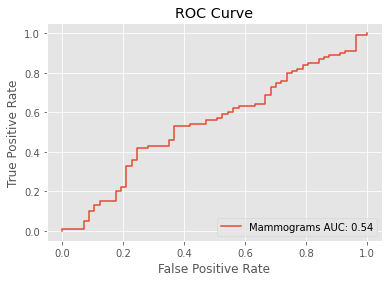

In [27]:
plt.style.use('ggplot')
from src import model_analysis
fig, ax = plt.subplots()
model_analysis.plot_roc(ax, 'Mammograms', y_true, predict)
plt.savefig('nn_roc_cc.png', dpi=350)

In [29]:
model_analysis.make_confusion('nn_cc', y_true, class_label)

In [20]:
data.to_csv('nn_mam_cc.csv')

In [23]:
data['y_true'].sum(), data['y_pred'].sum()

(100, 102)

In [20]:
# Sinograms
train_path = f'data/Mammograms/Tensor/train_sino'
val_path = f'data/Mammograms/Tensor/validation_sino/'
test_path = f'data/Mammograms/Tensor/test_sino/'
    
model = models.Xception_model(400,720)
model.compile_model(train_path, val_path)
model.fit()
files, predict = model.predict(test_path)

Found 1715 images belonging to 2 classes.
Found 414 images belonging to 2 classes.
107/107 [==============================] - 975s 9s/step - loss: 0.5289 - accuracy: 0.7369 - val_loss: 0.4335 - val_accuracy: 0.8275
Found 19 images belonging to 1 classes.


In [22]:
predict

array([[0.417198, 0.582802],
       [0.189953, 0.810047],
       [0.165048, 0.834952],
       [0.178158, 0.821842],
       [0.411128, 0.588872],
       [0.402891, 0.597109],
       [0.255918, 0.744082],
       [0.666596, 0.333404],
       [0.602572, 0.397428],
       [0.489646, 0.510354],
       [0.182259, 0.817741],
       [0.136673, 0.863328],
       [0.214958, 0.785042],
       [0.359438, 0.640562],
       [0.501152, 0.498848],
       [0.088958, 0.911042],
       [0.610419, 0.389581],
       [0.73852 , 0.26148 ],
       [0.572396, 0.427604]], dtype=float32)

## All the code for Xception Class

In [161]:
# Try new model because previous isn't working
# Using softmax so that we'll get probabilities for predictions

# Regular MLO mammograms
train_path = 'data/Mammograms/Tensor/train'
val_path = 'data/Mammograms/Tensor/validation'
test_path = 'data/Mammograms/Tensor/test'

width = 500
height = 277

# Data Generators
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    #  rescale=1./255,
                                      horizontal_flip=True) 
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
                                     #  rescale=1./255,)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# Data generators from directory
train_generator = training_datagen.flow_from_directory(train_path, 
                                                       target_size=(width, height), 
                                                       batch_size=16)
validation_generator = validation_datagen.flow_from_directory(val_path, 
                                                              target_size=(width,height), 
                                                              batch_size=16)
test_generator = test_datagen.flow_from_directory(test_path,
                                                 target_size=(width,height),
                                                 batch_size=16)


from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model

def create_transfer_model(input_size, n_categories, weights = 'imagenet'):
        # note that the "top" is not included in the weights below
        base_model = Xception(weights=weights,
                          include_top=False,
                          input_shape=input_size)
        
        model = base_model.output
        model = GlobalAveragePooling2D()(model)
        predictions = Dense(n_categories, activation='softmax')(model)
        model = Model(inputs=base_model.input, outputs=predictions)
        
        return model

Found 915 images belonging to 2 classes.
Found 227 images belonging to 2 classes.
Found 26 images belonging to 1 classes.


In [162]:
model = create_transfer_model((width,height,3),2) 

In [163]:
def print_model_properties(model, indices = 0):
    for i, layer in enumerate(model.layers[indices:]):
        print(i+indices, layer.name,layer.trainable)
print_model_properties(model)

0 input_15 True
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d_56 True
13 block2_pool True
14 batch_normalization_56 True
15 add_168 True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_57 True
23 block3_pool True
24 batch_normalization_57 True
25 add_169 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_58 True
33 block4_pool True
34 batch_normalization_58 True
35 add_170 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn

Change head

In [169]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

_ = change_trainable_layers(model, 132)
print_model_properties(model, 120)

120 block13_sepconv2 False
121 block13_sepconv2_bn False
122 conv2d_59 False
123 block13_pool False
124 batch_normalization_59 False
125 add_179 False
126 block14_sepconv1 False
127 block14_sepconv1_bn False
128 block14_sepconv1_act False
129 block14_sepconv2 False
130 block14_sepconv2_bn False
131 block14_sepconv2_act False
132 global_average_pooling2d_17 True
133 dense_17 True


In [170]:
# Compile model. Changed lr from 0.0005 to 0.005
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [168]:
# Train model can we use fit generator?
model.fit(train_generator,
                   steps_per_epoch=915//16,
                   epochs=4,
                   validation_data=validation_generator,
                   validation_steps=227//16)
#model.save_weights('models/weights.h5')
#model.save('models/transfermodel.h5')

Epoch 1/4
57/57 [==============================] - 383s 7s/step - loss: 0.0178 - acc: 0.9944 - val_loss: 1.5740 - val_acc: 0.6607
Epoch 2/4
57/57 [==============================] - 566s 10s/step - loss: 0.0305 - acc: 0.9855 - val_loss: 1.6903 - val_acc: 0.6384
Epoch 3/4
57/57 [==============================] - 441s 8s/step - loss: 0.0084 - acc: 0.9989 - val_loss: 1.5135 - val_acc: 0.6875
Epoch 4/4
57/57 [==============================] - 273s 5s/step - loss: 0.0184 - acc: 0.9967 - val_loss: 1.1118 - val_acc: 0.6875


134

In [45]:
## Shap
import json
import shap
# SHAP doesn't play nice with tensorflow 2.0
import tensorflow
from tensorflow.compat.v1.keras.backend import get_session

tensorflow.compat.v1.disable_v2_behavior()

In [31]:
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return get_session().run(model.layers[layer].input, feed_dict)

In [102]:
model.layers[0].input

<tf.Tensor 'input_2:0' shape=(?, 500, 277, 3) dtype=float32>

In [100]:
# Magic starts here. Layer number is important
# Get the image
train_images = 'data/Mammograms/Tensor/train/cancer/'
files = [f for f in os.listdir(train_images)]
lst = [cv2.imread(os.path.join(train_images,f)) for f in files]

# X is array of all the image inputs to train the model
X = np.asarray(lst)
to_explain = X[[39,41]]

print(X.shape)

l = 17

e = shap.GradientExplainer((model.layers[l].input, model.layers[-1].output),
    map2layer(X, l),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, l), ranked_outputs=2)

# get the names for the classes
#index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
#shap.image_plot(shap_values, to_explain, index_names)

(343, 500, 277, 3)


InvalidArgumentError: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,500,277,3]
	 [[node input_2 (defined at <ipython-input-54-9e2f44bc1658>:38) ]]

Original stack trace for 'input_2':
  File "/home/maureen/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/maureen/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 583, in start
    self.io_loop.start()
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 153, in start
    self.asyncio_loop.run_forever()
  File "/home/maureen/anaconda3/lib/python3.7/asyncio/base_events.py", line 538, in run_forever
    self._run_once()
  File "/home/maureen/anaconda3/lib/python3.7/asyncio/base_events.py", line 1782, in _run_once
    handle._run()
  File "/home/maureen/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 361, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 541, in execute_request
    user_expressions, allow_stdin,
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 300, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-a852a26e0f52>", line 1, in <module>
    model = create_transfer_model((width,height,3),2)
  File "<ipython-input-54-9e2f44bc1658>", line 38, in create_transfer_model
    input_shape=input_size)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/applications/xception.py", line 132, in Xception
    img_input = layers.Input(shape=input_shape)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_layer.py", line 295, in Input
    input_layer = InputLayer(**input_layer_config)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_layer.py", line 154, in __init__
    ragged=ragged)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py", line 1087, in placeholder
    x = array_ops.placeholder(dtype, shape=shape, name=name)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 3026, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6676, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 744, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3327, in _create_op_internal
    op_def=op_def)
  File "/home/maureen/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1791, in __init__
    self._traceback = tf_stack.extract_stack()


## Make predictions!

In [43]:
# Single image
#path = 'data/Histology/100X/test/test/SOB_B_TA-14-13200-100-001.png'
img = Image.open(img_path)
x = img_to_array(img)
images = np.array([x])
images.shape
model.predict(images)

ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

In [44]:
# predict on entire folder
predictions = model.predict(test_generator)
predictions, test_generator.filenames

ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.